# Final Project: Classifying beehive audio samples

Import the libraries to be used.

In [41]:
from os import listdir, sep
from os.path import isfile, join
import glob
import sys
import os
import random

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

## Load the data

Specify the path where the data is stored. The first one is used under windows, the second on Ubuntu. The dataset is mirrored [here](https://erikwouters.stackstorage.com/s/rXj8xPLK8OwKIHE).

In [66]:
# BUZZpath = join("D:", "Stack", "Courses", "KTH", "Courses", "05 - Scalable Machine Learning", "Final Project", "BUZZ1")
# BUZZ_path = join(sep, "media", "erik", "Data", "Stack", "Courses", "KTH", "Courses", "05 - Scalable Machine Learning", "Final Project", "BUZZ1")
BUZZ_path = join(sep, "home", "erik", "GitHub", "BUZZ1")
# BUZZ_path = "BUZZ1"

Enumerate each of the audio samples from the dataset in a list:
* `bee_files`: filenames of bee audio samples to be used for training
* `cricket_files`: filenames of cricket audio samples to be used for training
* `noise_files`: filenames of noise audio samples to be used for training
* `bee_val_files`: filenames of bee audio samples to be used for validation
* `cricket_val_files`: filenames of cricket audio samples to be used for validation
* `noise_val_files`: filenames of noise audio samples to be used for validation

In [67]:
bee_files = [f for f in listdir(join(BUZZ_path, "bee")) if isfile(join(BUZZ_path, "bee", f))]
cricket_files = [f for f in listdir(join(BUZZ_path, "cricket")) if isfile(join(BUZZ_path, "cricket", f))]
noise_files = [f for f in listdir(join(BUZZ_path, "noise")) if isfile(join(BUZZ_path, "noise", f))]

bee_val_files = [f for f in listdir(join(BUZZ_path, "out_of_sample_data_for_validation", "bee_test")) if isfile(join(BUZZ_path, "out_of_sample_data_for_validation", "bee_test", f))]
cricket_val_files = [f for f in listdir(join(BUZZ_path, "out_of_sample_data_for_validation", "cricket_test")) if isfile(join(BUZZ_path, "out_of_sample_data_for_validation", "cricket_test", f))]
noise_val_files = [f for f in listdir(join(BUZZ_path, "out_of_sample_data_for_validation", "noise_test")) if isfile(join(BUZZ_path, "out_of_sample_data_for_validation", "noise_test", f))]

The files are not consistently named. Some of them start with the label, then a sample number, then the IP address of the [BeePI](https://www.kickstarter.com/projects/970162847/beepi-a-multisensor-electronic-beehive-monitor "BeePI") (a Raspberry PI based audio recording device), followed by the date and time of recording.

These labels are not important for us, and because the data is also separated into folders we can work around the missing labels. Below are a few samples of filenames in each folder.

In [68]:
display(bee_files[:3], cricket_files[:3], noise_files[:3], bee_val_files[:3], cricket_val_files[:3], noise_val_files[:3])

['bee2266_192_168_4_9-2017-06-30_15-00-01.wav',
 'bee2489_192_168_4_6-2017-08-28_14-00-01.wav',
 'bee1335_192_168_4_6-2017-08-02_12-30-01.wav']

['cricket1314_192_168_4_6-2017-08-02_23-45-01.wav',
 'cricket2212_192_168_4_6-2017-09-02_23-30-01.wav',
 'cricket1777_192_168_4_6-2017-09-02_04-45-01.wav']

['noise1876.wav',
 'noise2874_2016-08-13_07-30-52.wav',
 'noise1893_2016-08-13_07-45-54.wav']

['192_168_4_6-2017-08-09_15-45-01_18.wav',
 '192_168_4_6-2017-08-09_15-15-01_17.wav',
 '192_168_4_6-2017-08-09_15-30-01_28.wav']

['cricket240_192_168_4_10-2017-08-18_23-45-01.wav',
 'cricket230_192_168_4_10-2017-08-18_23-45-01.wav',
 'cricket248_192_168_4_10-2017-08-18_23-45-01.wav']

['noise192_192_168_4_10-2017-07-09_04-45-01_26.wav',
 'noise28_192_168_4_10-2017-07-09_04-30-01_12.wav',
 'noise212_192_168_4_10-2017-07-09_04-45-01_9.wav']

We use `scipy.io`'s wavfile library to read the files.

In [69]:
# from scipy.io import wavfile

# sample_rate, samples = wavfile.read(join(BUZZ_path, "bee", bee_files[0]))
# sample_rate, samples = wavfile.read(join(BUZZpath, "cricket", cricketfiles[0]))
# sample_rate, samples = wavfile.read(join(BUZZpath, "noise", noisefiles[0]))

import librosa
samples, sample_rate = librosa.load(join(BUZZ_path, "bee", bee_files[0]))

The sample rate of all the files is 44100 Hz. The samples are stored as 16-bit integers in an array with 88244 samples for the first audio file.

In [70]:
sample_rate

22050

In [71]:
samples, len(samples)

(array([-0.00233346, -0.00225764, -0.00150069, ..., -0.00224996,
        -0.00169294, -0.00187797], dtype=float32), 44122)

To generate the spectrograms we use `matplotlib`'s `pyplot.specgram` library. This returns

This function splits an audio sample
into NFFT = 512 length segments and the spectrum of each segment is computed. The number
of overlap points between each segment was set to 384. The window size was 2048 and the hop
size was 2048/4 = 512. The scaling frequency was the same as the input audio sample’s frequency.
The windowed version of each segment was obtained with the default Hanning window function.
Each spectrogram was converted to an 100 × 100 image with a dpi of 300. Thus, the time and frequency
domains were treated equally, and were mapped to the range of [0, 99] each with each pixel value
approximating a frequency value at a particular point in time.

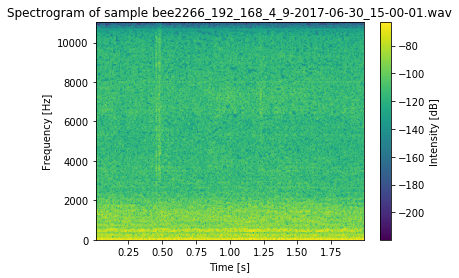

In [72]:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html
cmap = None #"gray"  # 'jet' 'None'
spectrum, freqs, t, im = plt.specgram(
    samples,
    NFFT=512,
    Fs=sample_rate,
    Fc=0,
    detrend=plt.mlab.detrend_none,
    window=plt.mlab.window_hanning,
    noverlap=384,
    cmap=cmap,
    xextent=None,
    pad_to=None,
    sides="default",
    scale_by_freq=True,
    mode="default",
    scale="default",
)

im.figure.axes[0].set_xlabel("Time [s]")
im.figure.axes[0].set_ylabel("Frequency [Hz]")
im.figure.axes[0].set_title("Spectrogram of sample {}".format(bee_files[0]))
plt.colorbar().set_label("Intensity [dB]")

In order to save an image of 100x100 pixels we set the figure size to match that size and remove all axes and whitespace from the plot. Below is an example of a spectrogram. 

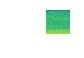

In [76]:
dpi = 300
im.figure.set_size_inches(100 / dpi, 100 / dpi)
im.figure.frameon = False
im.figure.axes[0].set_axis_off()
im.figure.axes[0].set_position([0.0, 0.0, 1.0, 1.0])
display(im.figure)
# im.figure.savefig("test.png", dpi=dpi)

We create a function `wav2spec` that can be used to convert an audio sample to a spectrogram. It will output a `.png` image with a filename like `{category}_{sample number}.png`, where the sample number is printed with leading zeros such that it has five digits.

In [77]:
def wav2spec(
    filename, readdir, savedir, category=None, nr=None, im_size=[100, 100], dpi=300, reader="librosa" # reader="scipy"
):
    if reader is "scipy":
        sample_rate, samples = wavfile.read(join(readdir, filename))
    elif reader is "librosa":
        samples, sample_rate = librosa.load(join(readdir, filename))
    else:
        assert False, "Invalid .wav reader"
    spectrum, freqs, t, im = plt.specgram(
        samples,
        NFFT=512,
        Fs=sample_rate,
        Fc=0,
        detrend=plt.mlab.detrend_none,
        window=plt.mlab.window_hanning,
        noverlap=384,
        cmap="gray",
        xextent=None,
        pad_to=None,
        sides="default",
        scale_by_freq=True,
        mode="default",
        scale="default",
    )
    im.figure.set_size_inches(im_size[0] / dpi, im_size[1] / dpi)
    im.figure.frameon = False
    im.figure.axes[0].set_axis_off()
    im.figure.axes[0].set_position([0.0, 0.0, 1.0, 1.0])
    if category is None or nr is None:
        im.figure.savefig(join(savedir, filename.replace(".wav", ".png")), dpi=dpi)
    else:
        im.figure.savefig(join(savedir, "{}_{:05d}.png".format(category, nr)), dpi=dpi)

The sample numbers will be unique across all samples and start from 0.

In [78]:
sample_nr = 0
# category = "bee"
# print("{}_{:05d}.png".format(category, samplenr))

This loop generates all the spectrograms for the training set of bee samples.

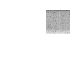

In [79]:
for bee_file in bee_files:
	wav2spec(bee_file,join(BUZZ_path, "bee"),join(BUZZ_path, "trainset"), "bee", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the training set of cricket samples.

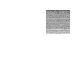

In [80]:
for cricket_file in cricket_files:
	wav2spec(cricket_file,join(BUZZ_path, "cricket"),join(BUZZ_path, "trainset"), "cricket", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the training set of noise samples.

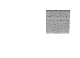

In [81]:
for noise_file in noise_files:
	wav2spec(noise_file,join(BUZZ_path, "noise"),join(BUZZ_path, "trainset"), "noise", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the validation set of bee samples.

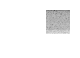

In [82]:
for bee_val_file in bee_val_files:
	wav2spec(bee_val_file,join(BUZZ_path,"out_of_sample_data_for_validation","bee_test"),join(BUZZ_path, "validationset"), "bee", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the validation set of cricket samples.

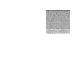

In [83]:
for cricket_val_file in cricket_val_files:
	wav2spec(cricket_val_file,join(BUZZ_path,"out_of_sample_data_for_validation","cricket_test"),join(BUZZ_path, "validationset"), "cricket", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the validation set of noise samples.

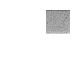

In [84]:
for noise_val_file in noise_val_files:
	wav2spec(noise_val_file,join(BUZZ_path,"out_of_sample_data_for_validation","noise_test"),join(BUZZ_path, "validationset"), "noise", sample_nr)
	sample_nr+=1

Select 100 spectrograms of each category and move them to the testset directory.

In [85]:
bee_train_filename_paths = glob.glob(join(BUZZ_path, "trainset") + sep + "bee*.png")
cricket_train_filename_paths = glob.glob(join(BUZZ_path, "trainset") + sep + "cricket*.png")
noise_train_filename_paths = glob.glob(join(BUZZ_path, "trainset") + sep + "noise*.png")
display(bee_train_filename_paths[:3])
display(cricket_train_filename_paths[:3])
display(noise_train_filename_paths[:3])

['/home/erik/GitHub/BUZZ1/trainset/bee_00816.png',
 '/home/erik/GitHub/BUZZ1/trainset/bee_00561.png',
 '/home/erik/GitHub/BUZZ1/trainset/bee_01148.png']

['/home/erik/GitHub/BUZZ1/trainset/cricket_05155.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_03707.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_04352.png']

['/home/erik/GitHub/BUZZ1/trainset/noise_06423.png',
 '/home/erik/GitHub/BUZZ1/trainset/noise_06450.png',
 '/home/erik/GitHub/BUZZ1/trainset/noise_07845.png']

In [86]:
bee_test_filename_paths = random.sample(bee_train_filename_paths, 100)
cricket_test_filename_paths = random.sample(cricket_train_filename_paths, 100)
noise_test_filename_paths = random.sample(noise_train_filename_paths, 100)

In [87]:
for bee_test_filename_path in bee_test_filename_paths:
# 	display(bee_test_filename_path, bee_test_filename_path.replace(sep + "trainset" + sep + "bee_", sep + "testset" + sep + "bee_"))
	os.rename(bee_test_filename_path, bee_test_filename_path.replace(sep + "trainset" + sep + "bee_", sep + "testset" + sep + "bee_"))

for cricket_test_filename_path in cricket_test_filename_paths:
	os.rename(cricket_test_filename_path, cricket_test_filename_path.replace(sep + "trainset" + sep + "cricket_", sep + "testset" + sep + "cricket_"))
	
for noise_test_filename_path in noise_test_filename_paths:
	os.rename(noise_test_filename_path, noise_test_filename_path.replace(sep + "trainset" + sep + "noise_", sep + "testset" + sep + "noise_"))

## Machine Learning

Import the libraries and make this notebook's output stable across runs.

In [88]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

List the available devices to run the model on.

In [89]:
with tf.Session() as sess:
    devices = sess.list_devices()
print(devices)

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 14673343755448108650)]


This device has a GPU and Cuda support.

In [90]:
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
    print(tf.test.is_built_with_cuda())
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


## Import the data
First take a look at them to see if they are correct.

In [91]:
train_filename_paths = glob.glob(join(BUZZ_path, "trainset") + sep + "*.png")
validation_filename_paths = glob.glob(join(BUZZ_path, "validationset") + sep + "*.png")
test_filename_paths = glob.glob(join(BUZZ_path, "testset") + sep + "*.png")

display(train_filename_paths[:10])
display(validation_filename_paths[:10])

['/home/erik/GitHub/BUZZ1/trainset/cricket_05155.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_03707.png',
 '/home/erik/GitHub/BUZZ1/trainset/noise_06423.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_04352.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_05866.png',
 '/home/erik/GitHub/BUZZ1/trainset/noise_06450.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_04707.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_04643.png',
 '/home/erik/GitHub/BUZZ1/trainset/cricket_05397.png',
 '/home/erik/GitHub/BUZZ1/trainset/bee_00561.png']

['/home/erik/GitHub/BUZZ1/validationset/cricket_09558.png',
 '/home/erik/GitHub/BUZZ1/validationset/bee_09202.png',
 '/home/erik/GitHub/BUZZ1/validationset/noise_10052.png',
 '/home/erik/GitHub/BUZZ1/validationset/cricket_09891.png',
 '/home/erik/GitHub/BUZZ1/validationset/noise_09939.png',
 '/home/erik/GitHub/BUZZ1/validationset/cricket_09455.png',
 '/home/erik/GitHub/BUZZ1/validationset/bee_09391.png',
 '/home/erik/GitHub/BUZZ1/validationset/cricket_09622.png',
 '/home/erik/GitHub/BUZZ1/validationset/noise_10239.png',
 '/home/erik/GitHub/BUZZ1/validationset/noise_10122.png']

In [92]:
print("Train: {}; Val: {}; Test: {}".format(len(train_filename_paths), len(validation_filename_paths), len(test_filename_paths)))

Train: 8810; Val: 1150; Test: 300


Now, it is wise to trainslate the classes directly into `int`s, as it will be easier to manage when calculating the cross entropy.

In [93]:
name_to_numeric = {"bee": 0, "cricket": 1, "noise": 2}


def get_class_from_path(path):
    class_name = (os.path.split(path)[-1]).split("_")[0]
    numerical_class = name_to_numeric[class_name]
    return numerical_class

In [94]:
train_labels = list(map(get_class_from_path, train_filename_paths))
validation_labels = list(map(get_class_from_path, validation_filename_paths))
test_labels = list(map(get_class_from_path, test_filename_paths))

We check that the classes are assigned correctly, as we encoded the class in the file name.

In [95]:
for pathname, classname in zip(train_filename_paths[:10], train_labels[:10]):
    print("{} {}".format(classname, pathname))

1 /home/erik/GitHub/BUZZ1/trainset/cricket_05155.png
1 /home/erik/GitHub/BUZZ1/trainset/cricket_03707.png
2 /home/erik/GitHub/BUZZ1/trainset/noise_06423.png
1 /home/erik/GitHub/BUZZ1/trainset/cricket_04352.png
1 /home/erik/GitHub/BUZZ1/trainset/cricket_05866.png
2 /home/erik/GitHub/BUZZ1/trainset/noise_06450.png
1 /home/erik/GitHub/BUZZ1/trainset/cricket_04707.png
1 /home/erik/GitHub/BUZZ1/trainset/cricket_04643.png
1 /home/erik/GitHub/BUZZ1/trainset/cricket_05397.png
0 /home/erik/GitHub/BUZZ1/trainset/bee_00561.png


In [96]:
for pathname, classname in zip(validation_filename_paths[:10], validation_labels[:10]):
    print("{} {}".format(classname, pathname))

1 /home/erik/GitHub/BUZZ1/validationset/cricket_09558.png
0 /home/erik/GitHub/BUZZ1/validationset/bee_09202.png
2 /home/erik/GitHub/BUZZ1/validationset/noise_10052.png
1 /home/erik/GitHub/BUZZ1/validationset/cricket_09891.png
2 /home/erik/GitHub/BUZZ1/validationset/noise_09939.png
1 /home/erik/GitHub/BUZZ1/validationset/cricket_09455.png
0 /home/erik/GitHub/BUZZ1/validationset/bee_09391.png
1 /home/erik/GitHub/BUZZ1/validationset/cricket_09622.png
2 /home/erik/GitHub/BUZZ1/validationset/noise_10239.png
2 /home/erik/GitHub/BUZZ1/validationset/noise_10122.png


In [97]:
for pathname, classname in zip(test_filename_paths[:10], test_labels[:10]):
    print("{} {}".format(classname, pathname))

0 /home/erik/GitHub/BUZZ1/testset/bee_00816.png
2 /home/erik/GitHub/BUZZ1/testset/noise_06628.png
0 /home/erik/GitHub/BUZZ1/testset/bee_02314.png
0 /home/erik/GitHub/BUZZ1/testset/bee_01014.png
1 /home/erik/GitHub/BUZZ1/testset/cricket_05977.png
0 /home/erik/GitHub/BUZZ1/testset/bee_01210.png
0 /home/erik/GitHub/BUZZ1/testset/bee_00999.png
0 /home/erik/GitHub/BUZZ1/testset/bee_01764.png
1 /home/erik/GitHub/BUZZ1/testset/cricket_03208.png
0 /home/erik/GitHub/BUZZ1/testset/bee_01662.png


Given that we had a non-standard dataset, we had to use the dataset API to implement our version of it.

First we need a function to decode the `png`s, we just need one channel as they are in grey scale, then we convert the `dtype` and finally we do a resize.
The resize is not strictly needed (as they are already 100x100) but in this way we declare the dimension of the input tensor, which is going to make debugging so much easier.

In [98]:
def parse_image_function(filename, label):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=1)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize is not actually needed but it is good to have the image dimensions in the
    # Tensor shape
    image = tf.image.resize_images(image, [100, 100])
    return image, label

We encountered memory problems, so the batch size had to be modified quite often.

In [99]:
BATCH_SIZE=64
VALIDATION_BATCH_SIZE=64

In [100]:
reset_graph()

The dataset is formed by tuples where the first element is the encoded image and the second is the class.

In [101]:
def get_inputs(filenames, labels, batch_size, parallel_tasks=4):
    num_samples = len(filenames)
    assert len(filenames) == len(labels), "Filenames and labels should have same length"
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(filenames), tf.constant(labels)))
    dataset = dataset.map(parse_image_function, num_parallel_calls=4)
    #     dataset = dataset.shuffle(num_samples)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)

    iterator = dataset.make_initializable_iterator()
    images, labels = iterator.get_next()
    iterator_init_op = iterator.initializer

    inputs = {"images": images, "labels": labels, "iterator_init_op": iterator_init_op}
    return inputs

This function resets the graph to the initial value and sets the batch size. It is used when a different model is trained on the same dataset.

In [102]:
def initialize_graph():
    reset_graph()
    train_inputs = get_inputs(train_filename_paths, train_labels, BATCH_SIZE)
    display(train_inputs)
    validation_inputs = get_inputs(validation_filename_paths, validation_labels, VALIDATION_BATCH_SIZE)
    display(validation_inputs)
    test_inputs = get_inputs(test_filename_paths, test_labels, len(test_filename_paths))
    display(test_inputs)

    return train_inputs, validation_inputs, test_inputs

In [103]:
train_inputs, validation_inputs, test_inputs = initialize_graph()

{'images': <tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>}

{'images': <tf.Tensor 'IteratorGetNext_1:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator_1' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int32>}

{'images': <tf.Tensor 'IteratorGetNext_2:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator_2' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext_2:1' shape=(?,) dtype=int32>}

Run a simple iteration to see if the labels are actually changing.
This also prints the device that the data is placed in to the console.

In [104]:
init = tf.global_variables_initializer()

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    init.run()
    sess.run(train_inputs["iterator_init_op"])
    print(sess.run(train_inputs["labels"]))
    print(sess.run(train_inputs["labels"]))
    print(sess.run(train_inputs["labels"]))

[1 1 2 1 1 2 1 1 1 0 2 0 0 1 1 0 0 1 0 0 0 2 1 1 1 0 2 0 2 2 0 2 2 0 2 0 1
 0 2 1 0 1 2 2 1 2 0 1 0 2 2 1 2 2 1 0 0 1 0 2 1 2 1 2]
[2 2 0 1 0 0 0 0 1 0 2 0 0 2 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 2 2 0 2 1 1
 2 1 0 0 2 0 2 2 1 1 2 0 0 2 2 0 0 1 2 1 0 2 0 0 1 1 1]
[2 2 1 0 1 0 0 2 2 0 2 0 1 2 1 2 2 1 1 1 0 0 2 0 1 0 0 0 1 2 0 2 1 1 0 1 2
 0 0 2 2 0 1 2 0 2 1 0 1 1 1 2 2 2 1 0 0 2 2 2 1 2 0 1]


In [105]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    sess.run(validation_inputs['iterator_init_op'])
    display(sess.run(validation_inputs['labels'])[:30])

array([1, 0, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 2, 0, 0, 0, 1, 2, 0, 1,
       2, 1, 1, 2, 1, 1, 1, 1], dtype=int32)

In [106]:
# just checking the tensor shape
train_inputs["images"]

<tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 1) dtype=float32>

## Models

### MLP
We decided to establish a simple baseline using an MLP with only 100 hidden units. Without any regularization in place. This was mainly to check that the dataset interface was working correctly.

We had to flatten the images to input them to the dense layer. Given that `ReLu` was used as an activation function, we initialized the biases to be slightly positive and the weights to be uniformly random distributed around 0. This to break the symmetry and avoid "zombie" neurons.

In [107]:
# a simple model, just a perceptron
# images = train_inputs["images"]
images = tf.placeholder(tf.float32, [None, 100, 100, 1])

flatten_images = tf.reshape(images, [-1, 100 * 100])

dense1 = tf.layers.dense(
    flatten_images,
    100,
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

dense2 = tf.layers.dense(
    dense1,
    3,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)


logits = dense2
logits.shape

TensorShape([Dimension(None), Dimension(3)])

As we are facing a multi-class classification problem. We opted for a `softmax` with `cross_entropy` loss function. And the optimizer is a standard gradient descent.

In [108]:
# labels = train_inputs['labels']
# print(labels.shape)
# raw_labels = tf.placeholder
# labels = tf.cast(labels, tf.int64)

raw_labels = tf.placeholder(tf.int32, [None])
labels = tf.cast(raw_labels, tf.int64)
predictions = tf.argmax(logits, 1)

print(predictions.shape)  # should be (?, )

loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
optimizer = tf.train.GradientDescentOptimizer(0.005)
train_op = optimizer.minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))
confusion_matrix = tf.confusion_matrix(labels, predictions)

(?,)


In the training process we store the desired metrics in a dictionary of lists that will be plotted later.

We use the `feed_dict` to replace the placeholders with the correct data, depending if we are training or evaluating.

In [109]:
init = tf.global_variables_initializer()

metrics = {
    "accuracy_train": [],
    "accuracy_val": [],
    "loss_train": [],
    "loss_val": [],
    "beat_train": [],
    "beat_val": [],
}

NUM_EPOCHS = 10

EVAL_EVERY_N_BATCHES = 5

with tf.Session() as sess:
    init.run()
    beat = 0
    # actual training
    for epoch in range(NUM_EPOCHS):
        print("Epoch {}".format(epoch))
        # restart from beginning of the dataset
        sess.run(train_inputs["iterator_init_op"])

        for batch_index in range(len(train_filename_paths) // BATCH_SIZE):
            train_images_data, train_labels_data = sess.run(
                [train_inputs["images"], train_inputs["labels"]]
            )
            print(train_images_data.shape)
            train_op_res, loss_train, accuracy_train = sess.run(
                [train_op, loss, accuracy],
                feed_dict={images: train_images_data, raw_labels: train_labels_data},
            )
            metrics["accuracy_train"].append(accuracy_train)
            metrics["loss_train"].append(loss_train)

            print("{}:{} Train Loss: {}".format(epoch, batch_index, loss_train))
            print("{}:{} Train Acc: {}".format(epoch, batch_index, accuracy_train))

            metrics["beat_train"].append(beat)

            # do the evaluation only some times
            if beat % EVAL_EVERY_N_BATCHES == 0:
                sess.run(validation_inputs["iterator_init_op"])
                validation_images_data, validation_labels_data = sess.run(
                    [validation_inputs["images"], validation_inputs["labels"]]
                )
                loss_val, accuracy_val = sess.run(
                    [loss, accuracy],
                    feed_dict={
                        images: validation_images_data,
                        raw_labels: validation_labels_data,
                    },
                )
                print("{}:{} Val Loss: {}".format(epoch, batch_index, loss_val))
                print("{}:{} Val Acc: {}".format(epoch, batch_index, accuracy_val))
                metrics["accuracy_val"].append(accuracy_val)
                metrics["loss_val"].append(loss_val)
                metrics["beat_val"].append(beat)
                confusion_matrix_res = sess.run(
                    [confusion_matrix],
                    feed_dict={
                        images: validation_images_data,
                        raw_labels: validation_labels_data,
                    },
                )
                print(confusion_matrix_res)

            beat += 1  # not very pythonic I know,
            print()

Epoch 0
(64, 100, 100, 1)
0:0 Train Loss: 2.9835572242736816
0:0 Train Acc: 0.328125
0:0 Val Loss: 8.004719734191895
0:0 Val Acc: 0.4375
[array([[ 0, 17,  0],
       [ 0, 28,  0],
       [ 0, 19,  0]], dtype=int32)]

(64, 100, 100, 1)
0:1 Train Loss: 7.643681049346924
0:1 Train Acc: 0.359375

(64, 100, 100, 1)
0:2 Train Loss: 12.481449127197266
0:2 Train Acc: 0.328125

(64, 100, 100, 1)
0:3 Train Loss: 2.43129301071167
0:3 Train Acc: 0.28125

(64, 100, 100, 1)
0:4 Train Loss: 6.507204055786133
0:4 Train Acc: 0.34375

(64, 100, 100, 1)
0:5 Train Loss: 11.331620216369629
0:5 Train Acc: 0.25
0:5 Val Loss: 2.251850128173828
0:5 Val Acc: 0.296875
[array([[ 0,  0, 17],
       [ 0,  0, 28],
       [ 0,  0, 19]], dtype=int32)]

(64, 100, 100, 1)
0:6 Train Loss: 2.502495765686035
0:6 Train Acc: 0.328125

(64, 100, 100, 1)
0:7 Train Loss: 4.7910261154174805
0:7 Train Acc: 0.5

(64, 100, 100, 1)
0:8 Train Loss: 1.29427170753479
0:8 Train Acc: 0.46875

(64, 100, 100, 1)
0:9 Train Loss: 1.805260181

We define a simple plotting function to take a look at the training behavior.

In [116]:
def plot_metrics(metrics, figsize=(15, 5), y_lim=None):
    _x_train = metrics["beat_train"]
    _x_val = metrics["beat_val"]
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    # loss ax
    axes[0].plot(_x_train, metrics["loss_train"], label="train")
    axes[0].plot(_x_val, metrics["loss_val"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("batches")
    if y_lim is not None:
        axes[0].set_ylim(*y_lim)
    axes[0].legend()

    # accuracy ax
    axes[1].plot(_x_train, metrics["accuracy_train"], label="train")
    axes[1].plot(_x_val, metrics["accuracy_val"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("batches")
    axes[1].legend()
    
    return fig

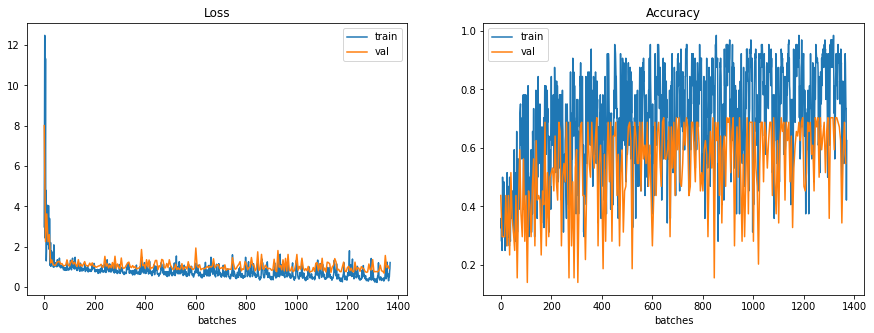

In [111]:
fig = plot_metrics(metrics)

The results of the simple MLP with 100 hidden units gives a very instable accuracy, but almost always better than a fair coin toss (33%, since we are classifiyng 3 labels).

## Convolutional Architecture

We now implement a convolutional architecture to exploit the spatial information contained in the spectrogram (that includes both temporal and frequency information), that was previously not exploited by the MLP as the imput was flattened.

In [112]:
train_inputs, validation_inputs, test_inputs = initialize_graph()

{'images': <tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>}

{'images': <tf.Tensor 'IteratorGetNext_1:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator_1' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int32>}

{'images': <tf.Tensor 'IteratorGetNext_2:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator_2' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext_2:1' shape=(?,) dtype=int32>}

We followed the guidelnes from Kulyukin et. al. (2018) to develop the convolutional architecture.

We decided to not introduce any initial regularization and follow the "deep learning recipe" of first lowering the bias (thus reaching overfitting) and then lower the variance using regularization.

In [113]:
images = tf.placeholder(tf.float32, [None, 100, 100, 1])

conv1 = tf.layers.conv2d(
    images,
    padding="same",
    filters=100,
    kernel_size=(3, 3),
    strides=(1, 1),
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

max_pool1 = tf.layers.max_pooling2d(
    conv1, padding="same", pool_size=(2, 2), strides=(2, 2), name="max_pool1"
)

conv2 = tf.layers.conv2d(
    max_pool1,
    padding="same",
    filters=200,
    kernel_size=(3, 3),
    strides=(1, 1),
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.zeros,
)

conv3 = tf.layers.conv2d(
    conv2,
    padding="same",
    filters=200,
    kernel_size=(3, 3),
    strides=(1, 1),
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.zeros,
)

max_pool2 = tf.layers.max_pooling2d(
    conv3, padding="same", pool_size=(2, 2), strides=(2, 2), name="max_pool2"
)


flatten_images = tf.reshape(max_pool2, [-1, 25 * 25 * 200])

dense1 = tf.layers.dense(
    flatten_images,
    50,
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
    # dropout 0.5
)

dense2 = tf.layers.dense(
    dense1,
    3,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

display(conv1.shape)
display(max_pool1.shape)
display(conv2.shape)
display(conv3.shape)
display(max_pool2.shape)
display(dense1.shape)
display(dense2.shape)

logits = dense2

# labels = train_inputs['labels']
# print(labels.shape)
# raw_labels = tf.placeholder
# labels = tf.cast(labels, tf.int64)

raw_labels = tf.placeholder(tf.int32, [None])
labels = tf.cast(raw_labels, tf.int64)
predictions = tf.argmax(logits, 1)

print(predictions.shape)  # should be (?, )

loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
# optimizer = tf.train.GradientDescentOptimizer(0.005)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))
confusion_matrix = tf.confusion_matrix(labels, predictions)

# logits.shape

TensorShape([Dimension(None), Dimension(100), Dimension(100), Dimension(100)])

TensorShape([Dimension(None), Dimension(50), Dimension(50), Dimension(100)])

TensorShape([Dimension(None), Dimension(50), Dimension(50), Dimension(200)])

TensorShape([Dimension(None), Dimension(50), Dimension(50), Dimension(200)])

TensorShape([Dimension(None), Dimension(25), Dimension(25), Dimension(200)])

TensorShape([Dimension(None), Dimension(50)])

TensorShape([Dimension(None), Dimension(3)])

(?,)


The convolutional architecture has much more weights than the MLP, thus this posed us some challenges from the point of view of the memory management.

The K1100M GPU that was used for training had only 2 GB of memory. It has a compute capability of 3.0, so the pre-compiled binaries from PyPi are not available for this device. For a different course I experimented with compiling tensorflow, so a manually compiled version of tensorflow was used.

The only solution was to lower the batch size both for training and evaluation. This meant that to complete the evaluation on the validation set, which contains 1150 images, we had to aggregate the metrics and then compute the average. We decided not to compute the confusion matrix, but this was a mistake as we could just sum the obtained numpy arrays.

In [114]:
init = tf.global_variables_initializer()

metrics = {
    "accuracy_train": [],
    "accuracy_val": [],
    "loss_train": [],
    "loss_val": [],
    "beat_train": [],
    "beat_val": [],
}

NUM_EPOCHS = 10

EVAL_EVERY_N_BATCHES = 10

with tf.Session() as sess:
    init.run()
    beat = 0
    # actual training
    for epoch in range(NUM_EPOCHS):
        print("Epoch {}".format(epoch))
        # restart from beginning of the dataset
        sess.run(train_inputs["iterator_init_op"])

        for batch_index in range(len(train_filename_paths) // BATCH_SIZE):
            train_images_data, train_labels_data = sess.run(
                [train_inputs["images"], train_inputs["labels"]]
            )
            print(train_images_data.shape)
            train_op_res, loss_train, accuracy_train = sess.run(
                [train_op, loss, accuracy],
                feed_dict={images: train_images_data, raw_labels: train_labels_data},
            )
            metrics["accuracy_train"].append(accuracy_train)
            metrics["loss_train"].append(loss_train)

            print("{}:{} Train Loss: {}".format(epoch, batch_index, loss_train))
            print("{}:{} Train Acc: {}".format(epoch, batch_index, accuracy_train))

            metrics["beat_train"].append(beat)

            # do the evaluation only some times
            if beat % EVAL_EVERY_N_BATCHES == 0:
                print("Calculating Eval")
                val_accuracies = []
                val_losses = []
                for batch_index in range(
                    len(validation_filename_paths) // VALIDATION_BATCH_SIZE
                ):
                    sess.run(validation_inputs["iterator_init_op"])
                    validation_images_data, validation_labels_data = sess.run(
                        [validation_inputs["images"], validation_inputs["labels"]]
                    )
                    loss_val, accuracy_val = sess.run(
                        [loss, accuracy],
                        feed_dict={
                            images: validation_images_data,
                            raw_labels: validation_labels_data,
                        },
                    )
                    val_accuracies.append(accuracy_val)
                    val_losses.append(loss_val)

                avg_val_accuracy = np.mean(val_accuracies)
                avg_val_loss = np.mean(val_losses)
                print("{}:{} Val Loss: {}".format(epoch, batch_index, avg_val_loss))
                print("{}:{} Val Acc: {}".format(epoch, batch_index, avg_val_accuracy))
                metrics["accuracy_val"].append(avg_val_accuracy)
                metrics["loss_val"].append(avg_val_loss)
                metrics["beat_val"].append(beat)
                # confusion_matrix_res = sess.run([confusion_matrix], feed_dict={images: validation_images_data, raw_labels: validation_labels_data  })
                # print(confusion_matrix_res)

            beat += 1  #  not very pythonic I know,
            print()

Epoch 0
(64, 100, 100, 1)
0:0 Train Loss: 48.44499969482422
0:0 Train Acc: 0.328125
Calculating Eval
0:16 Val Loss: 84.4651870727539
0:16 Val Acc: 0.265625

(64, 100, 100, 1)
0:1 Train Loss: 74.42282104492188
0:1 Train Acc: 0.390625

(64, 100, 100, 1)
0:2 Train Loss: 235.2161407470703
0:2 Train Acc: 0.3125

(64, 100, 100, 1)
0:3 Train Loss: 142.58279418945312
0:3 Train Acc: 0.390625

(64, 100, 100, 1)
0:4 Train Loss: 64.088623046875
0:4 Train Acc: 0.34375

(64, 100, 100, 1)
0:5 Train Loss: 65.74461364746094
0:5 Train Acc: 0.25

(64, 100, 100, 1)
0:6 Train Loss: 21.717693328857422
0:6 Train Acc: 0.453125

(64, 100, 100, 1)
0:7 Train Loss: 25.90777587890625
0:7 Train Acc: 0.34375

(64, 100, 100, 1)
0:8 Train Loss: 32.39014434814453
0:8 Train Acc: 0.25

(64, 100, 100, 1)
0:9 Train Loss: 18.252431869506836
0:9 Train Acc: 0.359375

(64, 100, 100, 1)
0:10 Train Loss: 7.757978439331055
0:10 Train Acc: 0.265625
Calculating Eval
0:16 Val Loss: 4.188257217407227
0:16 Val Acc: 0.203125

(64, 100,

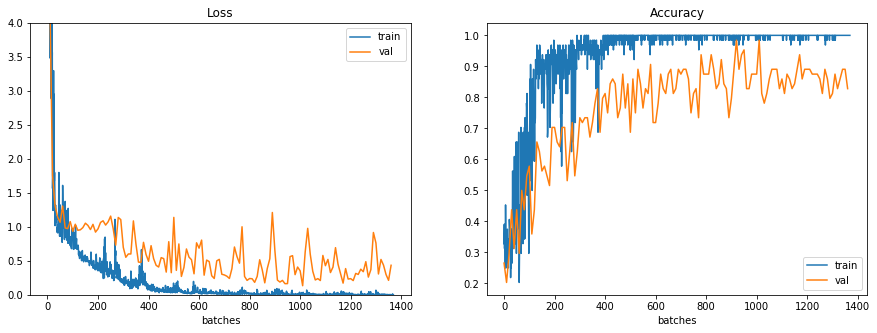

In [117]:
fig = plot_metrics(metrics, y_lim=(0, 4))
fig.savefig("../Images/Conv_overfitting.png")

We can see that the model quickly reaches an overfitting condition with 100% accuracy on the train batch. So we decided to interrupt the training and introduce some regularization

### Regularization

To regularize we opted for an `l2` regularization with a weight decay of 0.001 on the convolutional layers. While we introduced a dropout layer with keep probability of 0.5 as a last layer before the output, this should regularize the classifier part of the network.

In [118]:
train_inputs, validation_inputs, test_inputs = initialize_graph()

{'images': <tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>}

{'images': <tf.Tensor 'IteratorGetNext_1:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator_1' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int32>}

{'images': <tf.Tensor 'IteratorGetNext_2:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator_2' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext_2:1' shape=(?,) dtype=int32>}

In [ ]:
images = tf.placeholder(tf.float32, [None, 100, 100, 1])

conv1 = tf.layers.conv2d(
    images,
    padding="same",
    filters=100,
    kernel_size=(3, 3),
    strides=(1, 1),
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
)

max_pool1 = tf.layers.max_pooling2d(
    conv1, padding="same", pool_size=(2, 2), strides=(2, 2), name="max_pool1"
)

conv2 = tf.layers.conv2d(
    max_pool1,
    padding="same",
    filters=200,
    kernel_size=(3, 3),
    strides=(1, 1),
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.zeros,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
)

conv3 = tf.layers.conv2d(
    conv2,
    padding="same",
    filters=200,
    kernel_size=(3, 3),
    strides=(1, 1),
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.zeros,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
)

max_pool2 = tf.layers.max_pooling2d(
    conv3, padding="same", pool_size=(2, 2), strides=(2, 2), name="max_pool2"
)


flatten_images = tf.reshape(max_pool2, [-1, 25 * 25 * 200])

dense1 = tf.layers.dense(
    flatten_images,
    50,
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
    # dropout 0.5
)

is_training = tf.placeholder(dtype=tf.bool)
pkeep = tf.placeholder(dtype=tf.float32)

dropout1 = tf.layers.dropout(inputs=dense1, rate=pkeep, training=is_training)

dense2 = tf.layers.dense(
    dropout1,
    3,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)


display(conv1.shape)
display(max_pool1.shape)
display(conv2.shape)
display(conv3.shape)
display(max_pool2.shape)
display(dense1.shape)
display(dense2.shape)


logits = dense2

# labels = train_inputs['labels']
# print(labels.shape)
# raw_labels = tf.placeholder
# labels = tf.cast(labels, tf.int64)

raw_labels = tf.placeholder(tf.int32, [None])
labels = tf.cast(raw_labels, tf.int64)
predictions = tf.argmax(logits, 1)

print(predictions.shape)  # should be (?, )

loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
# optimizer = tf.train.GradientDescentOptimizer(0.005)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))
confusion_matrix = tf.confusion_matrix(labels, predictions)

# logits.shape

In [ ]:
init = tf.global_variables_initializer()

metrics = {
    "accuracy_train": [],
    "accuracy_val": [],
    "loss_train": [],
    "loss_val": [],
    "beat_train": [],
    "beat_val": [],
}

NUM_EPOCHS = 10

EVAL_EVERY_N_BATCHES = 10

with tf.Session() as sess:
    init.run()
    beat = 0
    # actual training
    for epoch in range(NUM_EPOCHS):
        print("Epoch {}".format(epoch))
        # restart from beginning of the dataset
        sess.run(train_inputs["iterator_init_op"])

        for batch_index in range(len(train_filename_paths) // BATCH_SIZE):
            train_images_data, train_labels_data = sess.run(
                [train_inputs["images"], train_inputs["labels"]]
            )
            print(train_images_data.shape)
            train_op_res, loss_train, accuracy_train = sess.run(
                [train_op, loss, accuracy],
                feed_dict={
                    images: train_images_data,
                    raw_labels: train_labels_data,
                    pkeep: 0.5,
                    is_training: True,
                },
            )
            metrics["accuracy_train"].append(accuracy_train)
            metrics["loss_train"].append(loss_train)

            print("{}:{} Train Loss: {}".format(epoch, batch_index, loss_train))
            print("{}:{} Train Acc: {}".format(epoch, batch_index, accuracy_train))

            metrics["beat_train"].append(beat)

            # do the evaluation only some times
            if beat % EVAL_EVERY_N_BATCHES == 0:
                print("Calculating Eval")
                val_accuracies = []
                val_losses = []
                for batch_index in range(
                    len(validation_filename_paths) // VALIDATION_BATCH_SIZE
                ):
                    sess.run(validation_inputs["iterator_init_op"])
                    validation_images_data, validation_labels_data = sess.run(
                        [validation_inputs["images"], validation_inputs["labels"]]
                    )
                    loss_val, accuracy_val = sess.run(
                        [loss, accuracy],
                        feed_dict={
                            images: validation_images_data,
                            raw_labels: validation_labels_data,
                            pkeep: 0.5,
                            is_training: False,
                        },
                    )
                    val_accuracies.append(accuracy_val)
                    val_losses.append(loss_val)

                avg_val_accuracy = np.mean(val_accuracies)
                avg_val_loss = np.mean(val_losses)
                print("{}:{} Val Loss: {}".format(epoch, batch_index, avg_val_loss))
                print("{}:{} Val Acc: {}".format(epoch, batch_index, avg_val_accuracy))
                metrics["accuracy_val"].append(avg_val_accuracy)
                metrics["loss_val"].append(avg_val_loss)
                metrics["beat_val"].append(beat)
                # confusion_matrix_res = sess.run([confusion_matrix], feed_dict={images: validation_images_data, raw_labels: validation_labels_data  })
                # print(confusion_matrix_res)

            beat += 1  #  not very pythonic I know,

            print()

In [ ]:
fig = plot_metrics(metrics, y_lim=(1, 1.3))
fig.savefig("../Images/Conv_regularized.png")

## Discussion

As we can see, we where not able to reproduce the results from the paper. The results are quite disappoing, at most. It appears that the regularization strategy is way too aggressive as the loss function quickly reaches a stationary position and neither the bias nor the variance are decreasing. 

As a critique to ourselves, we have definitely underestimated the time and effort necessary for the preparation of the data. Interfacing the dataset with the tensorflow machinery was not easy at all, but it was interesting to see how it works, rather than just downloading an already mande dataset. Also the reshaping and subsampling of the images took way more time than expected, we had to multi-thread the process to obtain the dataset in a reasonable time. All of this basically eroded all the time allocated to the actual training of the model.

The code for the 1 dimensional convolutional networks are provided, but not the one for the spectrogram classification.
Some information are still lacking, like the deatils on the initialization of the weights as well as the optimizer used.
Also, we decided to use grayscale images, already forecasting the possible memory problem. This can indeed have contributed to a significant loss of information.
We used the same time and frequency scale, but the intensity with 3 channels in much more dense.

The use of spectrograms to classify short audio samples can be related to how humans percieve sound. The shape of the ear and the hairs that connect to the nervous system produce a signal similar to a spectrogram, and the nervous system is comparable to the convolutional neural network.


## Future Works
We decided to follow the paper and translate the spectrograms in png images, but this step is largely un-needed as the spectrogram is already a bidimensional matrix, where each cell is an indicator of the frequency intensity. Thus, using directly this matrix should maintain the information as intact as possible.
In the paper is mentioned that they used a squared 100x100 image to make the frequency and time information equally apparent. Although this can be reached by modifiyng the spectrogram extraction and not resizing an image.

If one decides to maintain the image strategy, different colormaps could be evaluated. This can be very interesting to link human and CNN perception.

In a second iteration of the work, the data interface can be greatly improved, maybe directly passing the `iterator` to the `feed_dict` and having the batch size as a runtime parameter as well. The cells containing the training phase could be standardized and enclosed in a function. Finally the tensorflow dashboard could have been used to track the training in real time.

In [4]:
import tensorflow as tf
import os
import random
from progress.bar import Bar
import librosa

In [5]:
class data_set(object):
    """Parse and load the training audio files into a tensorflow dataset"""

    # `labels[i]` is the label for the audio in `filenames[i]`
    def __init__(self, filenames, labels, N = 256, batch_size = 25):
        self.N = N
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(lambda filename, label: tuple(tf.py_func(self._parse_file, [filename, label], [tf.float32, label.dtype])))
        dataset = dataset.shuffle(buffer_size=500)
        batched_dataset = dataset.batch(batch_size)
        batched_dataset = batched_dataset.repeat()

        self.iterator = batched_dataset.make_one_shot_iterator()
        self.next_element = self.iterator.get_next()

    def _parse_file(self, filename, label):
        audio_arr, sr = librosa.load(filename)
        return audio_arr[:self.N], label

In [6]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('f', '', 'kernel')

tf.app.flags.DEFINE_string(
    "train_dir", BUZZ_path, "The directory containing all of the files"
)
tf.app.flags.DEFINE_string(
    "test_dir",
    os.path.join(BUZZ_path, "out_of_sample_data_for_validation"),
    "The directory to save the test files",
)
tf.app.flags.DEFINE_integer("k", 20, "Percent of train files to become test files")
tf.app.flags.DEFINE_boolean("do_move", False, "Actually move the files via `os.rename`")

In [7]:
def get_filenames(dir):
    fn_arr = []
    for file in os.listdir(dir):
        if file.endswith(".wav"):
            fn_arr.append(file)

    return fn_arr

In [8]:
def get_test_arr(train_arr):
    k = FLAGS.k * 0.01
    random.shuffle(train_arr)
    return train_arr[: int(len(train_arr) * k)]

In [9]:
def rename_files(arr, dir):
    bar = Bar("Moving " + dir, max=len(arr))
    for filename in arr:
        current = os.path.join(os.path.join(FLAGS.train_dir, dir), filename)
        new = os.path.join(os.path.join(FLAGS.test_dir, dir), filename)
        if FLAGS.do_move:
            os.rename(current, new)
        bar.next()
    bar.finish()

In [10]:
bee_train_filenames = get_filenames(os.path.join(FLAGS.train_dir, "bee"))
cricket_train_filenames = get_filenames(os.path.join(FLAGS.train_dir, "cricket"))
noise_train_filenames = get_filenames(os.path.join(FLAGS.train_dir, "noise"))

bee_test_filenames = get_test_arr(bee_train_filenames)
cricket_test_filenames = get_test_arr(cricket_train_filenames)
noise_test_filenames = get_test_arr(noise_train_filenames)

rename_files(bee_test_filenames, "bee")
rename_files(cricket_test_filenames, "cricket")
rename_files(noise_test_filenames, "noise")

In [11]:
class CNN(object):
    """A CNN to classify bee hive audio"""
    def __init__(self, N=256, num_classes=3):
        self.N = N
        self.num_classes = num_classes
        self.x = tf.placeholder(tf.float32, shape=[None, N], name='input_audio')
        self.y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='audio_class')

    def _weight_variable(self, shape, name=''):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name)

    def _bias_variable(self, shape, name=''):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name)

    def _conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def _max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    def build(self):
        with tf.variable_scope("model", initializer=tf.random_uniform_initializer()) as scope:
            input_layer = tf.add(tf.matmul(self.x, self._weight_variable([self.N,1024], 'input_layer')), self._bias_variable([1024], 'input_bias')) 
            input_layer = tf.reshape(input_layer, [-1, 32, 32, 1])
            
            W_conv1 = self._weight_variable([5, 5, 1, 32], 'input_conv_weights')
            b_conv1 = self._bias_variable([32], 'input_conv_bias')
            
            h_conv1 = tf.nn.relu(self._conv2d(input_layer, W_conv1) + b_conv1)
            h_pool1 = self._max_pool_2x2(h_conv1)

            W_conv2 = self._weight_variable([5, 5, 32, 64], 'hidden_1_weights')
            b_conv2 = self._bias_variable([64], 'hidden_1_bias')

            h_conv2 = tf.nn.relu(self._conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = self._max_pool_2x2(h_conv2)

            W_conv3 = self._weight_variable([5, 5, 64, 128], 'hidden_2_weights')
            b_conv3 = self._bias_variable([128], 'hidden_2_bias')

            h_conv3 = tf.nn.relu(self._conv2d(h_pool2, W_conv3) + b_conv3)
            h_pool3 = self._max_pool_2x2(h_conv3)

            W_fc1 = self._weight_variable([1024 * 2, 1024], 'fc_1_weights')
            b_fc1 = self._bias_variable([1024], 'fc_1_bias')

            h_pool3_flat = tf.reshape(h_pool3, [-1, 1024 * 2])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob)

            W_fc2 = self._weight_variable([1024, self.num_classes], 'fc_2_weights')
            b_fc2 = self._bias_variable([self.num_classes], 'fc_2_bias')

            self.logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

        with tf.variable_scope("training", initializer=tf.random_uniform_initializer()) as scope:
            cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_, logits=self.logits))
            self.train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

            self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y_, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        self.saver = tf.train.Saver()

In [ ]:
tf.flags.DEFINE_string("checkpoint_path", os.path.join(FLAGS.train_dir, "ckpt"),
        "File, file pattern, or directory of checkpoints")
tf.flags.DEFINE_integer("epochs", 80000,
        "Number of training iterations")
tf.flags.DEFINE_integer("save_step", 1000,
        "Number of steps in between checkpoints")
tf.flags.DEFINE_integer("test_steps", 16000,
        "Number of steps to run the test and build accuracy")
tf.flags.DEFINE_boolean("train", True,
        "Flag for training the model")
tf.flags.DEFINE_boolean("test", True,
        "Flag for testing the model")
tf.flags.DEFINE_integer("num_hidden", 3,
        "The number of hidden layers in the input")
tf.flags.DEFINE_integer("N", 32768,
        "The length of the input data (will be padded/trunc)")
tf.flags.DEFINE_integer("hidden_nodes", 256,
        "The number of hidden layer nodes")
tf.flags.DEFINE_integer("num_classes", 3,
        "The number of classes")
tf.flags.DEFINE_integer("batch_size", 5,
        "Batch Size")

In [13]:
def add_filenames_and_labels(fn_arr, lbl_arr, label, dir):
    for file in os.listdir(dir):
        if file.endswith(".wav"):
            fn_arr.append(os.path.join(dir, file))
            lbl_arr.append(label)

In [14]:
train_filenames = []
train_labels = []
add_filenames_and_labels(train_filenames, train_labels, [1,0,0], os.path.join(FLAGS.train_dir, "bee"))
add_filenames_and_labels(train_filenames, train_labels, [0,1,0], os.path.join(FLAGS.train_dir, "cricket"))
add_filenames_and_labels(train_filenames, train_labels, [0,0,1], os.path.join(FLAGS.train_dir, "noise"))

In [15]:
test_filenames= []
test_labels = []
add_filenames_and_labels(test_filenames, test_labels, [1,0,0], os.path.join(FLAGS.test_dir, "bee_test"))
add_filenames_and_labels(test_filenames, test_labels, [0,1,0], os.path.join(FLAGS.test_dir, "cricket_test"))
add_filenames_and_labels(test_filenames, test_labels, [0,0,1], os.path.join(FLAGS.test_dir, "noise_test"))

In [16]:
model = CNN(FLAGS.N, FLAGS.num_classes)

In [17]:
train_data = data_set(tf.constant(train_filenames), tf.constant(train_labels), FLAGS.N, FLAGS.batch_size)
test_data = data_set(tf.constant(test_filenames), tf.constant(test_labels), FLAGS.N, FLAGS.batch_size)

In [18]:
def train_model(sess):
    """Train the model on the given training data for the given number of epochs in FLAGS"""
    print('Training Model')
    bar = Bar("Training", max=FLAGS.epochs, suffix='%(percent)d%% - %(eta)ds')
    for i in range(FLAGS.epochs):
        train_audio, train_lbl = sess.run(train_data.next_element)
        if i % FLAGS.save_step == 0:
            train_accuracy = model.accuracy.eval(feed_dict={model.x: train_audio, model.y_: train_lbl, model.keep_prob: 1.0})
            print('\nstep %d, training accuracy %g' % (i, train_accuracy))
            model.saver.save(sess, os.path.join(FLAGS.checkpoint_path, "model.ckpt"), i)
        model.train_step.run(feed_dict={model.x: train_audio, model.y_: train_lbl, model.keep_prob: 0.6})
        bar.next()
    bar.finish()
    save_path = model.saver.save(sess, os.path.join(FLAGS.checkpoint_path, "model.ckpt"), FLAGS.epochs)
    print('Model saved at ' + save_path)

In [19]:
def test_model(sess):
    """Test the model on the given testing data"""
    print('Testing Model')
    bar = Bar("Testing", max=FLAGS.test_steps, suffix='%(percent)d%% - %(eta)ds')
    total_acc = 0
    for i in range(FLAGS.test_steps):
        test_audio, test_labels = sess.run(test_data.next_element)
        acc = model.accuracy.eval(feed_dict={model.x: test_audio, model.y_: test_labels, model.keep_prob: 1.0})
        if i % int(FLAGS.test_steps * .1) == 0:
            print('\ntest accuracy %g' % acc)
        total_acc += acc
        bar.next()
    bar.finish()
    print('Avg. test accuracy %g' % (total_acc / FLAGS.test_steps))

In [20]:
with tf.Session() as sess:
    print('Building Model')
    model.build()
    sess.run(tf.global_variables_initializer())
    print('Trying to restore model')
    try:
        model.saver.restore(sess, tf.train.latest_checkpoint(FLAGS.checkpoint_path))
        print('Model restored from checkpoint')
    except:
        print('Couldn\'t load checkpoint from ' + FLAGS.checkpoint_path)

    if FLAGS.train:
        train_model(sess)
    if FLAGS.test:
        test_model(sess)

Building Model
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Trying to restore model
Couldn't load checkpoint from /media/erik/Data/Stack/Courses/KTH/Courses/05 - Scalable Machine Learning/Final Project/BUZZ1/ckpt
Training Model

step 0, training accuracy 1

step 1000, training accuracy 1

step 2000, training accuracy 1

step 3000, training accuracy 1

step 4000, training accuracy 1

step 5000, training accuracy 1

step 6000, training accuracy 1

step 7000, training accuracy 0.8

step 8000, training accuracy 1

step 9000, training accuracy 1

step 10000, training accuracy 1

step 11000, training accuracy 1

step 12000, training accuracy 1

step 13000, training accuracy 1

step 14000, training accuracy 1

step 15000, training accuracy 1

step 16000, training accuracy 1

step 17000, training accuracy 1

step 18000, training accuracy 1

step 1900

In [31]:
# tf.flags.DEFINE_string("checkpoint_path", "data/ckpt",
#         "Model checkpoint file or directory containing a "
#         "model checkpoint file.")
tf.flags.DEFINE_string("input_files", os.path.join(FLAGS.train_dir, "testset"),
        "Location/file pattern of audio file(s) to classify.")
# FLAGS.input_files = os.path.join(FLAGS.train_dir, "testset")

In [32]:
def print_audio_class(audio_class, sess):
    argmax = tf.argmax(audio_class, 1)
    #print(img_class)
    if tf.equal(argmax, tf.argmax([[1,0,0]], 1)).eval(session=sess):
        print('Audio is of a bee')
    elif tf.equal(argmax, tf.argmax([[0,1,0]], 1)).eval(session=sess):
        print('Audio is of a cricket')
    else:
        print('Audio is of noise')

In [33]:
model = CNN(32768, 3)

In [35]:
with tf.Session() as sess:
    # 1. Build and Restore Model
    model.build()
    sess.run(tf.global_variables_initializer())
    model.saver.restore(sess, tf.train.latest_checkpoint(FLAGS.checkpoint_path))

    filenames = []
    for file_pattern in FLAGS.input_files.split(","):
        filenames.extend(tf.gfile.Glob(file_pattern))
    print("Running classification on %d files matching %s" % (
                                          len(filenames), FLAGS.input_files))
    for filename in filenames: 
        # 2. Load and Pre-process Audio 
        audio_arr, sr = librosa.load(filename)
        
        # 3. Classify and Print result
        audio_class = sess.run(model.logits,feed_dict={model.x: [audio_arr[:32768]], model.keep_prob: 1.0})
        print_audio_class(audio_class, sess)